# Scenario 3 subtask 1: Estimate the True Number of Infections

# Clean Version

**Background:** 10/2020 - 1/2021 in Greater Boston area. Predicting cases from wastewater potentially reports closer to the truth than testing.

## **TASK 1:** Replicate the fitting excersize (A) in Section 3.2 <br>
paper: https://doi.org/10.1016/j.scitotenv.2022.159326.

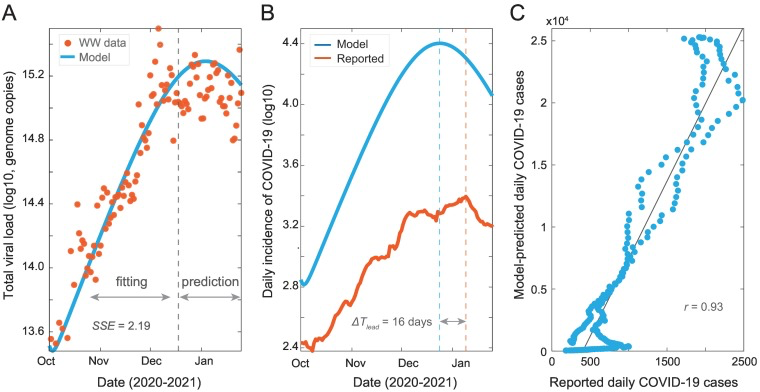

**Specifications:**
1. SEIR-V model
2. Fit $\lambda$, $\alpha$, and E(0).
3. Data found in supplementary materials
4. Simplify wherever necessary (e.g. fixed $\beta$)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyciemss.visuals.plots as plots
from pyciemss.PetriNetODE.interfaces import (
    load_and_sample_petri_model,
    load_and_calibrate_and_sample_petri_model,
    load_petri_model,
    setup_petri_model,
    sample
)
from pyciemss.utils.interface_utils import convert_to_output_format
from pyciemss.utils import get_tspan

from mira.sources.askenet.petrinet import model_from_url
from mira.metamodel import Distribution
from mira.modeling.askenet.petrinet import AskeNetPetriNetModel
from mira.modeling import Model
import urllib.request, json
import requests

### Plot the Data:

V
time              
0     3.424864e+13
1     7.482611e+13
2     1.107730e+14
3     1.455132e+14
4     1.789461e+14
...            ...
221   1.256720e+17
222   1.257698e+17
223   1.258096e+17
224   1.258676e+17
225   1.259472e+17

[226 rows x 1 columns]

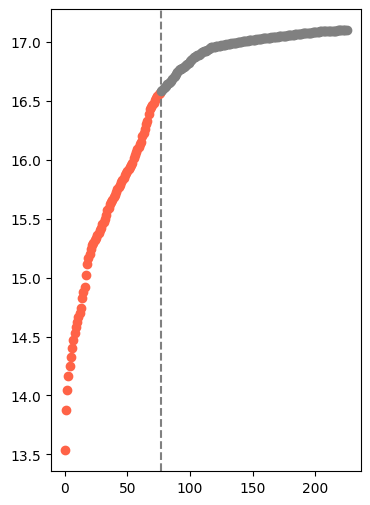

In [2]:
# Load Data
## This uses the cumsum() of the raw data
data_train = pd.read_csv('./data/processed_dataset_train.csv', index_col="time")
data_test  = pd.read_csv('./data/processed_dataset_test.csv', index_col="time")
data_whole = pd.read_csv('./data/processed_dataset.csv', index_col="time")
display(data_whole)

# Plot
plt.figure(figsize=(4,6))
plt.scatter(data_train.index, np.log10(data_train.V), color='tomato')
plt.scatter(data_test.index, np.log10(data_test.V), color='grey')
plt.axvline(77, linestyle='dashed', color='grey')

### Plot the Model:

In [3]:
SEIV_model_url  = "https://raw.githubusercontent.com/indralab/mira/hackathon2/notebooks/evaluation_2023.07/eval_scenario3_base.json"

raw = model_from_url(SEIV_model_url)
raw.parameters['lambda'].value = 9.06e-8
#raw.parameters['lambda'].distribution = Distribution(type="Uniform1", parameters={"minimum": 0, "maximum":2 * 9.06e-8})
raw.parameters['gamma'].value = 0.125
raw.parameters['beta'].value = 44852600
#raw.initials['E'].value = 1182
#raw.initials['V'].value = 1
print([(x, raw.parameters[x].value, raw.parameters[x].distribution) for x in raw.parameters])
print([(x, raw.initials[x].value) for x in raw.initials])

[('lambda', 9.06e-08, None), ('k', 0.3333333333333333, None), ('delta', 0.125, None), ('alpha', 500.0, Distribution(type='Uniform1', parameters={'minimum': 51.0, 'maximum': 796.0})), ('beta', 44852600, None), ('gamma', 0.125, None)]
[('S', 2300000.0), ('I', 0.0), ('E', 1000.0), ('V', 0.0)]


In [4]:
num_samples = 5
start_time = 0
end_time = 226 # between 10/02/2020 and 01/25/2021
num_timepoints = (end_time-start_time)*10 + 1
timepoints = list(get_tspan(start_time, end_time, num_timepoints).detach().numpy())

prior_samples = load_and_sample_petri_model(
        raw, num_samples, timepoints=timepoints,
    visual_options={"title": "3_base", "subset":["V_sol"]}, time_unit="days")

In [5]:
schema = plots.trajectories(pd.DataFrame(prior_samples["data"]), subset=".*_sol",
                            markers={"Training": 77},
                            points=data_whole.reset_index(drop=True).rename(columns={"V":"V_data"}))
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

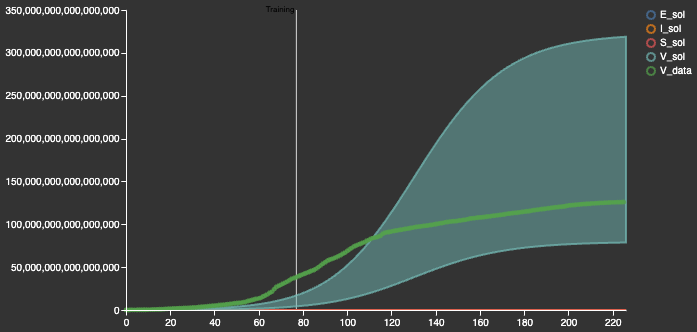

### Calibrate:

In [6]:
calibrated_samples = load_and_calibrate_and_sample_petri_model(
            raw,
            './data/processed_dataset_train.csv',
            5,
            timepoints=timepoints,
            num_iterations=2,
            visual_options={"title": "3_base", "subset":["V_sol"]}, time_unit="days")

/Users/zuck016/Projects/Proposals/ASKEM/build/pyciemss/src/pyciemss/PetriNetODE/interfaces.py:864: UserWarning: Observation ObservationEvent(time=6.773866971343523e-06, observation={'V': tensor(3.4249e+13)}) is not in the range [0, 2301000.0]. This may be an error!
  warnings.warn(f"Observation {obs} is not in the range [0, {petri.total_population}]. This may be an error!")
/Users/zuck016/Projects/Proposals/ASKEM/build/pyciemss/src/pyciemss/PetriNetODE/interfaces.py:864: UserWarning: Observation ObservationEvent(time=1.0000025033950806, observation={'V': tensor(7.4826e+13)}) is not in the range [0, 2301000.0]. This may be an error!
  warnings.warn(f"Observation {obs} is not in the range [0, {petri.total_population}]. This may be an error!")
/Users/zuck016/Projects/Proposals/ASKEM/build/pyciemss/src/pyciemss/PetriNetODE/interfaces.py:864: UserWarning: Observation ObservationEvent(time=2.0000081062316895, observation={'V': tensor(1.1077e+14)}) is not in the range [0, 2301000.0]. This may

In [7]:
schema = plots.trajectories(pd.DataFrame(calibrated_samples["data"]), subset=".*_sol",
                            markers={"Training": 77},
                            points=data_whole.reset_index(drop=True).rename(columns={"V":"V_data"}))
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

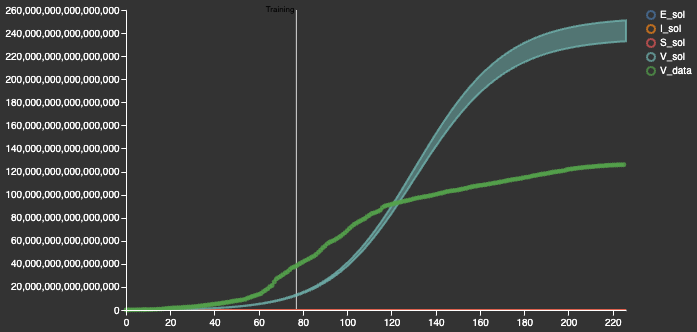

### Mimic the paper figure

In [8]:
# TODO

## **TASK 3:** Repeat with uncertainty over the paper's parameters.

In [16]:
#SEIV_model_url  = "https://raw.githubusercontent.com/indralab/mira/hackathon2/notebooks/evaluation_2023.07/eval_scenario3_base.json"
from mira.sources.askenet import model_from_json_file
SEIVCDU_model_json = 'ES3_detection_log10V.json'
#raw = model_from_url(SEIV_model_url)
raw = model_from_json_file(SEIVCDU_model_json)
raw.parameters['lambda'].value = 9.06e-8
raw.parameters['lambda'].distribution = Distribution(type="Uniform1",
                                                     parameters={"minimum": 0, "maximum":2 * 9.06e-8})
raw.parameters['gamma'].value = 0.125
raw.parameters['gamma'].distribution = Distribution(type="Uniform1",
                                                    parameters={"minimum": 0.04, "maximum":0.12})
raw.parameters['beta'].value = 44852600
print([(x, raw.parameters[x].value, raw.parameters[x].distribution) for x in raw.parameters])
print([(x, raw.initials[x].value) for x in raw.initials])

[('lambda', 9.06e-08, Distribution(type='Uniform1', parameters={'minimum': 0.0, 'maximum': 1.812e-07})), ('k', 0.5, None), ('delta', 0.125, None), ('alpha', 500.0, Distribution(type='Uniform1', parameters={'minimum': 51.0, 'maximum': 796.0})), ('beta', 44852600, None), ('gamma', 0.125, Distribution(type='Uniform1', parameters={'minimum': 0.04, 'maximum': 0.12}))]
[('S', 2300000.0), ('I', 0.0), ('E', 1000.0), ('V', 34248644946672.492), ('C', 0.0), ('D', 0.0), ('U', 0.0)]


In [17]:
num_samples = 5
start_time = 0
end_time = 226 # between 10/02/2020 and 01/25/2021
num_timepoints = (end_time-start_time)*10 + 1
timepoints = list(get_tspan(start_time, end_time, num_timepoints).detach().numpy())

prior_samples = load_and_sample_petri_model(
        raw, num_samples, timepoints=timepoints,
    visual_options={"title": "3_base", "subset":["V_sol"]}, time_unit="days")

In [18]:
schema = plots.trajectories(pd.DataFrame(prior_samples["data"]), subset=".*_sol",
                            markers={"Training": 77},
                            points=data_whole.reset_index(drop=True).rename(columns={"V":"V_data"}))
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

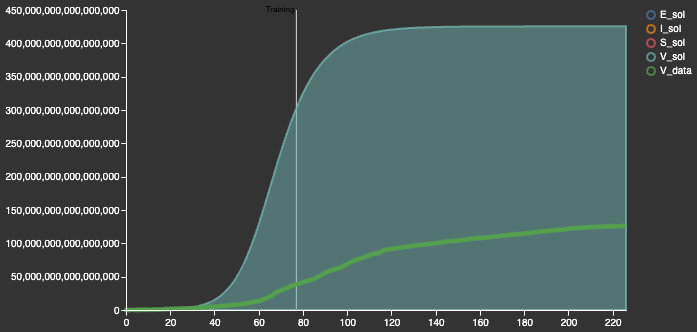

### Calibrate:

In [19]:
calibrated_samples = load_and_calibrate_and_sample_petri_model(
            raw,
            './data/processed_dataset_train.csv',
            5,
            timepoints=timepoints,
            num_iterations=20,
            visual_options={"title": "3_base", "subset":["V_sol"]}, time_unit="days")

/Users/zuck016/Projects/Proposals/ASKEM/build/pyciemss/src/pyciemss/PetriNetODE/interfaces.py:864: UserWarning: Observation ObservationEvent(time=1.0000090599060059, observation={'V': tensor(7.4826e+13)}) is not in the range [0, 34248648032256.0]. This may be an error!
  warnings.warn(f"Observation {obs} is not in the range [0, {petri.total_population}]. This may be an error!")
/Users/zuck016/Projects/Proposals/ASKEM/build/pyciemss/src/pyciemss/PetriNetODE/interfaces.py:864: UserWarning: Observation ObservationEvent(time=2.000009775161743, observation={'V': tensor(1.1077e+14)}) is not in the range [0, 34248648032256.0]. This may be an error!
  warnings.warn(f"Observation {obs} is not in the range [0, {petri.total_population}]. This may be an error!")
/Users/zuck016/Projects/Proposals/ASKEM/build/pyciemss/src/pyciemss/PetriNetODE/interfaces.py:864: UserWarning: Observation ObservationEvent(time=3.000009536743164, observation={'V': tensor(1.4551e+14)}) is not in the range [0, 34248648032

In [20]:
schema = plots.trajectories(pd.DataFrame(calibrated_samples["data"]), subset=".*_sol",
                            markers={"Training": 77},
                            points=data_whole.reset_index(drop=True).rename(columns={"V":"V_data"}))
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

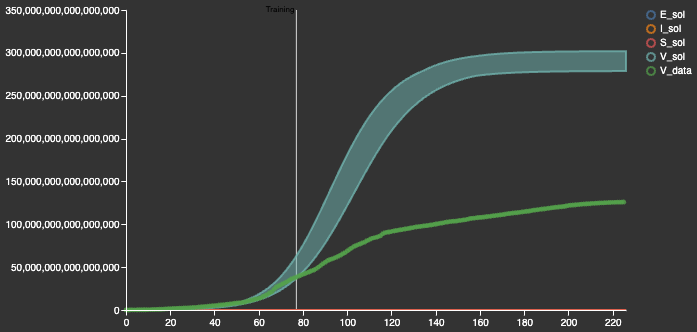

In [21]:
# View what values the calibration landed on
display(calibrated_samples["data"])

timepoint_id  sample_id  lambda_param  alpha_param  gamma_param  \
0                 0          0  9.009971e-08   496.969666     0.053162   
1                 1          0  9.009971e-08   496.969666     0.053162   
2                 2          0  9.009971e-08   496.969666     0.053162   
3                 3          0  9.009971e-08   496.969666     0.053162   
4                 4          0  9.009971e-08   496.969666     0.053162   
...             ...        ...           ...          ...          ...   
11300          2256          4  9.759790e-08   506.587463     0.056693   
11301          2257          4  9.759790e-08   506.587463     0.056693   
11302          2258          4  9.759790e-08   506.587463     0.056693   
11303          2259          4  9.759790e-08   506.587463     0.056693   
11304          2260          4  9.759790e-08   506.587463     0.056693   

       k_param  delta_param  beta_param         C_sol         D_sol  \
0          0.5        0.125  44852600.0  5.180707e-19  2.590353e-19   
1          0.5        0.125  44852600.0  5.074640e-01  2.537320e-01   
2          0.5        0.125  44852600.0  1.988849e+00  9.944247e-01   
3          0.5        0.125  44852600.0  4.385737e+00  2.192869e+00   
4          0.5        0.125  44852600.0  7.643613e+00  3.821806e+00   
...        ...          ...         ...           ...           ...   
11300      0.5        0.125  44852600.0  1.681156e+06  8.405782e+05   
11301      0.5        0.125  44852600.0  1.681160e+06  8.405800e+05   
11302      0.5        0.125  44852600.0  1.681163e+06  8.405816e+05   
11303      0.5        0.125  44852600.0  1.681172e+06  8.405858e+05   
11304      0.5        0.125  44852600.0  1.681176e+06  8.405878e+05   

             E_sol         I_sol         S_sol         U_sol         V_sol  \
0      1000.000000  5.000000e-08  2.300000e+06  2.590353e-19  3.424865e+13   
1       951.728577  4.847287e+01  2.300000e+06  2.537320e-01  3.430033e+13   
2       906.760986  9.402825e+01  2.299998e+06  9.944247e-01  3.445121e+13   
3       864.879639  1.368610e+02  2.299995e+06  2.192869e+00  3.469531e+13   
4       825.879883  1.771532e+02  2.299992e+06  3.821806e+00  3.502712e+13   
...            ...           ...           ...           ...           ...   
11300    89.569710  6.571075e+02  6.188377e+05  8.405782e+05  2.883438e+17   
11301    89.061501  6.533832e+02  6.188337e+05  8.405800e+05  2.883451e+17   
11302    88.556091  6.496791e+02  6.188296e+05  8.405816e+05  2.883465e+17   
11303    88.053459  6.459969e+02  6.188268e+05  8.405858e+05  2.883482e+17   
11304    87.553757  6.423348e+02  6.188228e+05  8.405878e+05  2.883496e+17   

        logV_obs  timepoint_days  
0      13.534644        0.000000  
1      13.535299        0.100000  
2      13.537205        0.200000  
3      13.540271        0.300000  
4      13.544405        0.400000  
...          ...             ...  
11300  17.459911      225.600006  
11301  17.459913      225.699997  
11302  17.459915      225.800003  
11303  17.459918      225.899994  
11304  17.459920      226.000000  

[11305 rows x 17 columns]

In [22]:
calibrated_samples['data'].to_csv('data/calibrated_samples_from_wastewater.csv', index=False)

**BONUS:** Use temperature data during fitting to replicate figure 3A. Prove that it improves fit.
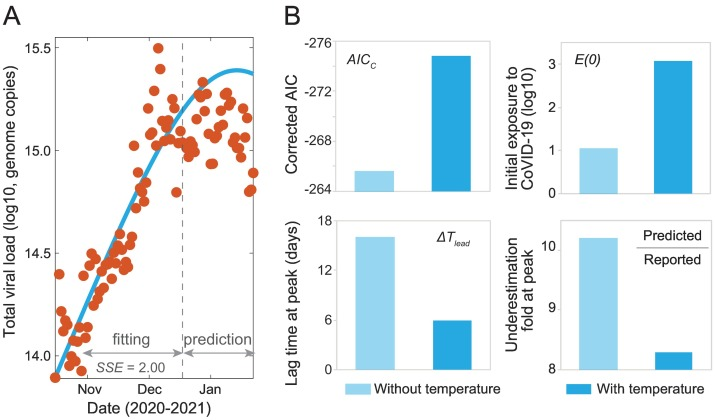

In [15]:
# TODO